<h1 align=center><font size = 5>Applied Data Science Capstone</font></h1>
<h1 align=center><font size = 4>Gyan Prakash Singh</font></h1>

### Introduction

Core problem is use of data science tools to find 3 candidate locations for setting up a fine dining restaurant in delhi. Factors which may lead to higher footfall such as number of high quality fine dining restaurants in the locality, other landmarks  bazaars, museums, art galleries, shopping centers, parking lots etc. need to be identified and explored to make a suitable model which may solve this problem. Foursquare location data will be utilized as core of our analysis. It will be used to extract information such as nearby venues of interest. We will also use data published by Office of the Registrar General & Census Commissioner, India
Ministry of Home Affairs, Government of India under national census.
 Census data contains extensive information ranging from population to households  amenities and assets. This data is avaliable at Tehsil (roughy translated to locality) level. It may be noted that car ownership is considered a sort of luxary in developing countries like India and not everyone owns a car as is normal in developed countries. It may be assumed that potential patrons of a fine dining restaurant will be car owners. We can first select a suitable number of districts/localities in delhi based on relative affluence of the neighbourhood and limit further analysis to these districts/localities only.

First, we do download all the dependencies.

In [1]:
pip install xlrd


The following command must be run outside of the IPython shell:

    $ pip install xlrd

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

#### Now we read the excel file containing data from the census of india into a dataframe. The data is saved on my google drive.

In [3]:
df=pd.read_excel('https://drive.google.com/u/0/uc?id=1FytkJWwTSzyE4o5Z3Ikbmz7n052DDBf5&export=download')

#### Now we perform some data wrangling operations to get data in suitable format.

In [4]:
df.head(3) #car term is percentage of population owning cars in particular tehsil

,district,tehsil code,tehsil,car
0,Central,445,Darya Ganj,8.5
1,Central,445,Darya Ganj,8.5
2,Central,445,Darya Ganj,8.5


In [4]:
df1=df

In [5]:
df2=df1.drop(['district','tehsil code'], axis=1)#drop columns district and tehsil code from df1 and put the data in df2
df2=df2.groupby(['tehsil'], as_index=False).mean()#group tehsils and take average of cars percentage
df2.head()


,tehsil,car
0,Chanakya Puri,20.400000
1,Civil Lines,18.750000
2,Connaught Place,30.000000
3,Darya Ganj,8.207692
4,Defence Colony,36.568000


In [6]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


In [7]:
df2plot=df2

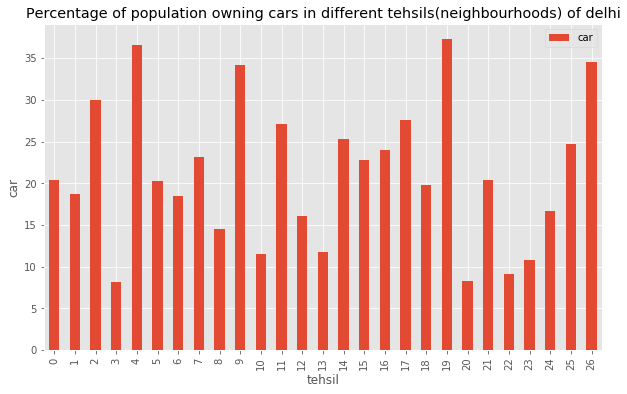

In [17]:
df2plot.plot(kind='bar', figsize=(10, 6))

plt.xlabel('tehsil') # add to x-label to the plot
plt.ylabel('car') # add y-label to the plot
plt.title('Percentage of population owning cars in different tehsils(neighbourhoods) of delhi') # add title to the plot

plt.show()

Now we sort the data in descending order of percentage car ownership. In next step, we select top 15 localities by slicing the data frame.

In [8]:
df2=df2.sort_values(by=['car'],ascending=False);#sor values of average car ownership in descending order
df2 = df2.reset_index(drop=True)#reset index
#slice df2 to get top 15 tehsils in terms of car ownership percentage
df2=df2[:15]
df2.shape

(15, 2)

In [9]:
df3=df2# copied data into a new data frames so that above steps need not be repeated, if needed.

In [10]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.21.0-py_0 conda-forge


geographiclib-1.50   | 34 KB     | ##################################### | 100% 
geopy-1.21.0         | 58 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


### _In next step, I have searched for latitude and logitude for each neighbourhood in a loop and added the information to the dataframe._

In [11]:
#loop through tehsil column of df3 and find latitude and longitude of each tehsil using geocode/Nominatim
lats=[]
longs=[]
for tehsil in df3['tehsil']:
    geolocator = Nominatim(user_agent="ny_explorer")
    if tehsil=='Chanakya Puri':
        address='chanakya puri, delhi'
    elif tehsil=='Parliament Street':
        address= 'Parliament Street, Delhi, India'
    else:
        address=tehsil +',  new delhi, india'
    location = geolocator.geocode(address)
    if location == None:
        lats.append(None)
        
    else:
        lats.append(location.latitude)#append the latitude/longitude to separate lists
        longs.append(location.longitude)
print('done')

    
    

done


In [12]:
#add the latitude and longitude lists to the dataframe df3
df3['latitude']=lats
df3['longitude']=longs

In [13]:
df3

,tehsil,car,latitude,longitude
0,Rajouri Garden,37.241176,28.642152,77.116060
1,Defence Colony,36.568000,28.571791,77.232010
2,Vivek Vihar,34.555556,28.669164,77.312267
3,Karol Bagh,34.187500,28.652998,77.189023
4,Connaught Place,30.000000,28.631383,77.219792
5,Preet Vihar,27.551613,28.641441,77.295259
6,Model Town,27.073333,28.702714,77.193991
7,Pahar Ganj,25.330000,28.639852,77.213031
8,Vasant Vihar,24.756667,28.560691,77.160791
9,Patel Nagar,23.971429,28.465564,77.039294


#### Now we have a dataframe containing top 15 localities of delhi in terms of car ownership percentage and latitude and logitude of each locality.
    

## In the next stage we will overlap this data on the map of delhi

geographical location of delhi

In [14]:
geolocator = Nominatim(user_agent="delhi_explorer")
loc = geolocator.geocode('new delhi')
lati = loc.latitude
longi = loc.longitude
print('The geograpical coordinate of Delhi are {}, {}.'.format(lati, longi))

The geograpical coordinate of Delhi are 28.6141793, 77.2022662.


Create a map of delhi with neighbourhoods superimposed.

In [15]:
# create map of Delhi using latitude and longitude values
map_delhi = folium.Map(location=[lati, longi], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df3['latitude'], df3['longitude'], df3['tehsil']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    
map_delhi

## In next step, we will get information about venues nearby each locality in a particular radius by using foursquare.

### Define foursquare credentials

In [16]:
CLIENT_ID = 'ML0TGX54A2KRRN1JF552ZZJMHMGK0VYGQL5OUEF14UVXN4Q5' # your Foursquare ID
CLIENT_SECRET = 'E401FZYASWMDWLB30TTGGDT5UZBCUBTELAO4Q4GBNAJZZX1U' # your Foursquare Secret
VERSION = '20200216' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ML0TGX54A2KRRN1JF552ZZJMHMGK0VYGQL5OUEF14UVXN4Q5
CLIENT_SECRET:E401FZYASWMDWLB30TTGGDT5UZBCUBTELAO4Q4GBNAJZZX1U


### Define a functino to get nearby venues

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### add the data to data frame delhi_venues

In [18]:
LIMIT = 150 # limit of number of venues returned by Foursquare API
delhi_venues = getNearbyVenues(names=df3['tehsil'],
                                   latitudes=df3['latitude'],
                                   longitudes=df3['longitude']
                                  )

Rajouri Garden
Defence Colony
Vivek Vihar
Karol Bagh
Connaught Place
Preet Vihar
Model Town
Pahar Ganj
Vasant Vihar
Patel Nagar
Hauz Khas
Parliament Street
Chanakya Puri
Saraswati Vihar
Delhi Cantonment


In [22]:
delhi_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rajouri Garden,28.642152,77.11606,Main Market Rajouri Garden,28.645729,77.121261,Market
1,Rajouri Garden,28.642152,77.11606,Pirates of The Grill,28.644371,77.111674,BBQ Joint
2,Rajouri Garden,28.642152,77.11606,Anjlika Pastry Shop,28.642521,77.123294,Bakery
3,Rajouri Garden,28.642152,77.11606,Zara | जा़रा,28.642468,77.106536,Clothing Store
4,Rajouri Garden,28.642152,77.11606,PVR Cinemas,28.642439,77.106500,Multiplex


In [23]:
delhi_venues.shape

(737, 7)

In [19]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighbourhood'] = delhi_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [delhi_onehot.columns[-1]] + list(delhi_onehot.columns[:-1])
delhi_onehot = delhi_onehot[fixed_columns]

delhi_onehot.head()

,Neighbourhood,Airport Terminal,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Garden,Bistro,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Concert Hall,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,English Restaurant,Event Space,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gift Shop,Gourmet Shop,Government Building,Gym,Gym / Fitness Center,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Internet Cafe,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Light Rail Station,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Motel,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Nightlife Spot,North Indian Restaurant,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Speakeasy,Spiritual Center,Stadium,Steakhouse,Tapas Restaurant,Tea Room,Theater,Tibetan Restaurant,Track,Train Station,Wine Bar,Yoga Studio
0,Rajouri Garden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rajouri Garden,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Rajouri Garden,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Rajouri Garden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Rajouri Garden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
delhi_score=delhi_onehot.groupby('Neighbourhood').sum().reset_index()
delhi_scoreT=delhi_score.T
delhi_score

,Neighbourhood,Airport Terminal,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Garden,Bistro,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Concert Hall,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,English Restaurant,Event Space,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gift Shop,Gourmet Shop,Government Building,Gym,Gym / Fitness Center,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Internet Cafe,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Light Rail Station,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Motel,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Nightlife Spot,North Indian Restaurant,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Speakeasy,Spiritual Center,Stadium,Steakhouse,Tapas Restaurant,Tea Room,Theater,Tibetan Restaurant,Track,Train Station,Wine Bar,Yoga Studio
0,Chanakya Puri,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,2,3,0,0,5,0,1,0,0,4,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,2,0,1,0,0,0,0,1,0,0,1,1,0
1,Connaught Place,0,0,1,2,2,0,0,1,0,2,0,5,1,1,0,0,0,0,0,0,0,9,3,1,0,4,0,1,0,2,0,1,0,1,0,0,3,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,2,0,0,0,8,0,0,1,1,17,0,0,3,0,1,0,0,1,0,4,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,1,2,0,0,0,0,0,0,0,1,2,1,0,0,0,0,0,1,1,1,0,0,0,0
2,Defence Colony,0,0,1,0,1,1,0,1,0,2,1,1,0,0,0,0,0,1,0,0,0,4,2,2,1,4,0,0,0,0,0,0,0,2,1,0,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,12,2,0,4,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Delhi Cantonment,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hauz Khas,0,0,0,0,4,0,1,0,0,0,1,3,1,0,0,0,0,1,0,0,0,8,2,0,0,11,0,0,0,0,0,1,0,2,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,8,0,0,0,0,0,0,1,1,0,1,3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,4,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,Karol Bagh,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,3,0,0,0,0,0,1,0,0,0,0,4,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Model Town,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,3,0,0,1,0,1,0,0,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,Pahar Ganj,0,0,0,0,1,0,0,1,0,2,0,7,1,1,0,1,1,0,0,0,0,7,3,1,0,3,0,0,0,2,0,1,0,1,0,0,4,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,12,0,0,1,1,15,0,0,1,0,1,0,0,1,1,4,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,3,2,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0
8,Parliament Street,1,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,7,0,1,0,0,3,0,1,2,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0

In [77]:
delhi_score.shape

(15, 123)

In [21]:
delhi_score.sum(axis = 1, skipna = True) 

0      38
1     100
2      71
3       8
4      69
5      29
6      21
7     100
8      41
9      39
10     23
11     49
12    100
13     39
14     15
dtype: int64

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
delhi_grouped = delhi_onehot.groupby('Neighbourhood').mean().reset_index()
delhi_grouped

,Neighbourhood,Airport Terminal,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Garden,Bistro,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Concert Hall,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,English Restaurant,Event Space,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gift Shop,Gourmet Shop,Government Building,Gym,Gym / Fitness Center,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Internet Cafe,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Light Rail Station,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Motel,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Nightlife Spot,North Indian Restaurant,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Speakeasy,Spiritual Center,Stadium,Steakhouse,Tapas Restaurant,Tea Room,Theater,Tibetan Restaurant,Track,Train Station,Wine Bar,Yoga Studio
0,Chanakya Puri,0.026316,0.000000,0.000000,0.00,0.026316,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.026316,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.026316,0.000000,0.026316,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.00,0.000000,0.026316,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.052632,0.078947,0.000000,0.000000,0.131579,0.00,0.026316,0.000000,0.00,0.105263,0.000000,0.026316,0.026316,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.026316,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.00,0.000000,0.000000,0.026316,0.000000,0.000,0.000000,0.00,0.000000,0.052632,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.052632,0.000000,0.026316,0.000000,0.000000,0.00,0.000000,0.026316,0.00,0.000000,0.026316,0.026316,0.000000
1,Connaught Place,0.000000,0.000000,0.010000,0.02,0.020000,0.000000,0.000000,0.010000,0.00,0.020000,0.000000,0.050000,0.010000,0.01,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.090000,0.030000,0.010000,0.000000,0.040000,0.000000,0.01,0.000000,0.02,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.030000,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.00,0.000000,0.000000,0.01,0.000000,0.000000,0.00000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.080000,0.00,0.000000,0.010000,0.01,0.170000,0.000000,0.000000,0.030000,0.000000,0.01,0.000000,0.000000,0.010000,0.000000,0.040000,0.000000,0.010000,0.000000,0.00,0.000000,0.010000,0.01,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.010,0.000000,0.01,0.010000,0.020000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.00,0.010000,0.010000,0.01,0.000000,0.000000,0.000000,0.000000
2,Defence Colony,0.000000,0.000000,0.014085,0.00,0.014085,0.014085,0.000000,0.014085,0.00,0.028169,0.014085,0.014085,0.000000,0.00,0.00,0.00,0.000000,0.014085,0.000000,0.000000,0.000,0.056338,0.028169,0.028169,0.014085,0.056338,0.000000,0.00,0.000000,0.00,0.0

In [88]:
delhi_grouped.shape

(15, 123)

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = delhi_grouped['Neighbourhood']

for ind in np.arange(delhi_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chanakya Puri,Hotel,Indian Restaurant,History Museum,Historic Site,Restaurant,Spa,Asian Restaurant,Internet Cafe,Park,Music Venue
1,Connaught Place,Indian Restaurant,Café,Hotel,Bar,Coffee Shop,Lounge,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Bakery
2,Defence Colony,Indian Restaurant,Market,Sandwich Place,Coffee Shop,Pizza Place,Café,Italian Restaurant,Fast Food Restaurant,Bakery,Donut Shop
3,Delhi Cantonment,Historic Site,Convenience Store,Coffee Shop,Plaza,Café,Cafeteria,Shopping Mall,History Museum,Gym / Fitness Center,Donut Shop
4,Hauz Khas,Coffee Shop,Indian Restaurant,Café,Pizza Place,Asian Restaurant,Market,Bar,Sandwich Place,Donut Shop,Chinese Restaurant


# Clustering

In [25]:
# set number of clusters
kclusters = 3

delhi_grouped_clustering = delhi_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 2, 1, 1, 1, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [31]:
df3.head()

,tehsil,car,latitude,longitude
0,Rajouri Garden,37.241176,28.642152,77.116060
1,Defence Colony,36.568000,28.571791,77.232010
2,Vivek Vihar,34.555556,28.669164,77.312267
3,Karol Bagh,34.187500,28.652998,77.189023
4,Connaught Place,30.000000,28.631383,77.219792


In [27]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

delhi_merged = df3

# merge delhi_grouped with df3 to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='tehsil')

delhi_merged # check the last columns!


,tehsil,car,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rajouri Garden,37.241176,28.642152,77.116060,1,Fast Food Restaurant,Indian Restaurant,Café,Shopping Mall,Multiplex,Restaurant,BBQ Joint,Hotel,Donut Shop,Coffee Shop
1,Defence Colony,36.568000,28.571791,77.232010,1,Indian Restaurant,Market,Sandwich Place,Coffee Shop,Pizza Place,Café,Italian Restaurant,Fast Food Restaurant,Bakery,Donut Shop
2,Vivek Vihar,34.555556,28.669164,77.312267,1,Indian Restaurant,BBQ Joint,Pool,Light Rail Station,Shop & Service,Juice Bar,Pizza Place,Bank,Italian Restaurant,Hotel
3,Karol Bagh,34.187500,28.652998,77.189023,1,Indian Restaurant,Fast Food Restaurant,Snack Place,Coffee Shop,Food & Drink Shop,Restaurant,Pizza Place,Café,Burrito Place,Light Rail Station
4,Connaught Place,30.000000,28.631383,77.219792,0,Indian Restaurant,Café,Hotel,Bar,Coffee Shop,Lounge,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Bakery
5,Preet Vihar,27.551613,28.641441,77.295259,1,Pizza Place,Indian Restaurant,Arcade,Dessert Shop,Shopping Mall,BBQ Joint,Café,Chinese Restaurant,Fast Food Restaurant,Food
6,Model Town,27.073333,28.702714,77.193991,1,Coffee Shop,Snack Place,Fast Food Restaurant,Pizza Place,Café,Indian Restaurant,Korean Restaurant,Light Rail Station,Food Truck,Donut Shop
7,Pahar Ganj,25.330000,28.639852,77.213031,0,Indian Restaurant,Hotel,Café,Bar,Lounge,Fast Food Restaurant,Coffee Shop,Pub,Chinese Restaurant,Deli / Bodega
8,Vasant Vihar,24.756667,28.560691,77.160791,1,Café,Chinese Restaurant,Indian Restaurant,Fast Food Restaurant,Pizza Place,Coffee Shop,Restaurant,Food & Drink Shop,Flea Market,Market
9,Patel Nagar,23.971429,28.465564,77.039294,0,Hotel,Indian Restaurant,Department Store,Coffee Shop,Brewery,Chinese Restaurant,Bakery,Café,Multiplex,Bus Station


In [33]:
delhi_merged

,tehsil,car,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rajouri Garden,37.241176,28.642152,77.116060,1,Fast Food Restaurant,Café,Indian Restaurant,Restaurant,Shopping Mall,Multiplex,Hotel,BBQ Joint,Coffee Shop,Donut Shop
1,Defence Colony,36.568000,28.571791,77.232010,1,Indian Restaurant,Market,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Pizza Place,Coffee Shop,Café,Chinese Restaurant,Donut Shop
2,Vivek Vihar,34.555556,28.669164,77.312267,0,Shop & Service,BBQ Joint,Light Rail Station,Pool,Pizza Place,Italian Restaurant,Indian Restaurant,Hotel,Athletics & Sports,Asian Restaurant
3,Karol Bagh,34.187500,28.652998,77.189023,1,Indian Restaurant,Fast Food Restaurant,Snack Place,Coffee Shop,Food & Drink Shop,Hotel,Café,Burrito Place,Light Rail Station,Pizza Place
4,Connaught Place,30.000000,28.631383,77.219792,0,Indian Restaurant,Café,Hotel,Bar,Lounge,Coffee Shop,Chinese Restaurant,Italian Restaurant,Bakery,Fast Food Restaurant
5,Preet Vihar,27.551613,28.641441,77.295259,1,Pizza Place,Dessert Shop,Arcade,Indian Restaurant,Café,South Indian Restaurant,Convenience Store,Hotel,Fast Food Restaurant,Plaza
6,Model Town,27.073333,28.702714,77.193991,1,Coffee Shop,Café,Fast Food Restaurant,Indian Restaurant,Pizza Place,Convenience Store,Frozen Yogurt Shop,Food Truck,Donut Shop,Light Rail Station
7,Pahar Ganj,25.330000,28.639852,77.213031,0,Indian Restaurant,Hotel,Café,Bar,Fast Food Restaurant,Lounge,Pub,Coffee Shop,Chinese Restaurant,Bakery
8,Vasant Vihar,24.756667,28.560691,77.160791,1,Café,Pizza Place,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Restaurant,Indian Restaurant,Furniture / Home Store,Nightlife Spot,Playground
9,Patel Nagar,23.971429,28.465564,77.039294,0,Hotel,Indian Restaurant,Department Store,Chinese Restaurant,Market,Restaurant,Lounge,Café,Pool,Clothing Store


In [28]:
# create map
map_clusters = folium.Map(location=[lati, longi], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['latitude'], delhi_merged['longitude'], delhi_merged['tehsil'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters